## About this notebook
This notebook ensembles the CLIP Interrogator, OFA model and ViT model.

In [1]:
ratio_ViT_B_16          = 0.74880
ratio_CLIP_Interrogator = 0.21120
ratio_OFA               = 0.04000

#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b> OFA </b></div>

[Original notebook](https://www.kaggle.com/code/mayukh18/ofa-transformer-lb-0-42644)

In [2]:
# Using the pre compiled wheel since we don't have internet on submission
!pip install -q /kaggle/input/stable-diffusion-data/transformers-4.18.0.dev0-py3-none-any.whl

In [3]:
import os
import sys
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import OFATokenizer, OFAModel
from transformers.models.ofa.generate import sequence_generator

import gc

In [4]:
CKPT_DIR = "/kaggle/input/stable-diffusion-data/OFA-large-caption/"
IMAGE_DIR = "/kaggle/input/stable-diffusion-image-to-prompts/images"

BATCH_SIZE = 24

# Loading the pretrained OFA model

In [5]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480
patch_resize_transform = transforms.Compose([
        lambda image: image.convert("RGB"),
        transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
        transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std)
    ])

tokenizer = OFATokenizer.from_pretrained(CKPT_DIR)
model = OFAModel.from_pretrained(CKPT_DIR, use_cache=False).cuda()
txt = " what does the image describe?"
inputs = tokenizer([txt], return_tensors="pt").input_ids

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  """
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


/kaggle/input/stable-diffusion-data/OFA-large-caption/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Model EDA

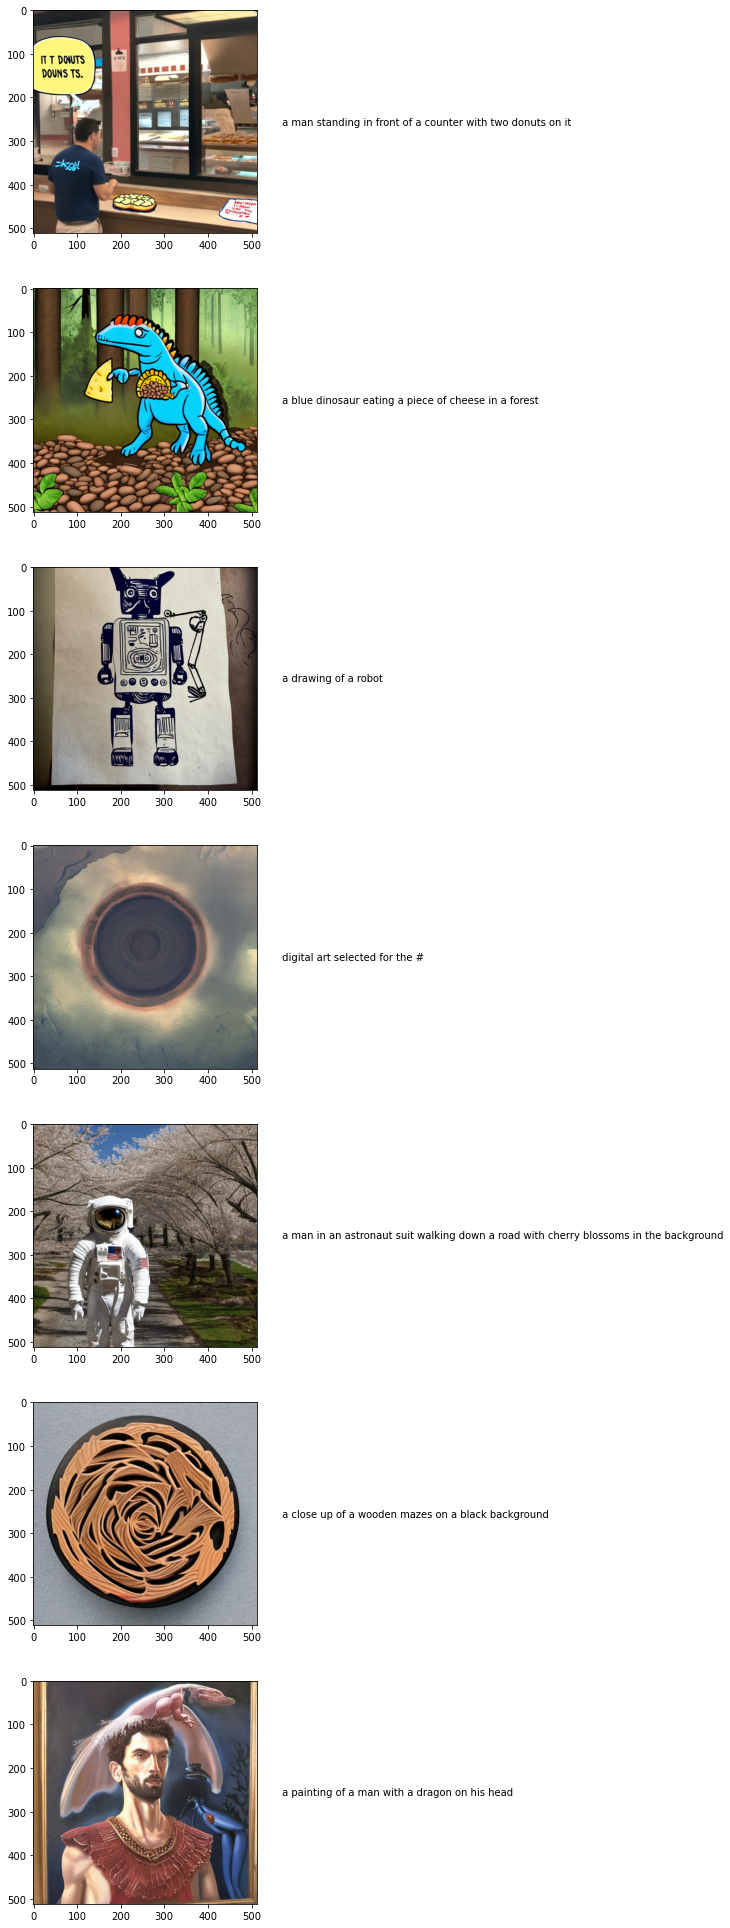

In [6]:
sample_images = glob.glob("/kaggle/input/stable-diffusion-image-to-prompts/images/*")[:7]
fig, ax = plt.subplots(7,1, figsize=(4,35))

for i,impath in enumerate(sample_images):
    image = Image.open(impath)
    image_t = patch_resize_transform(image).cuda().unsqueeze(0)
    out = model.generate(inputs.cuda(), patch_images=image_t.cuda(), num_beams=5, no_repeat_ngram_size=2)
    out_captions = tokenizer.batch_decode(out, skip_special_tokens=True)
    ax[i].imshow(image)
    ax[i].text(1.1, .5, out_captions[0], horizontalalignment='left', verticalalignment='center', transform=ax[i].transAxes)

# Inference

In [7]:
sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

comp_path = Path('../input/stable-diffusion-image-to-prompts/')
st_model = SentenceTransformer('/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2')

In [8]:
class ImageGen(Dataset):
    def __init__(self, root, batch_size=32):
        self.root = root
        self.im_paths = os.listdir(self.root)
        self.batch_size = batch_size
        self.sz = len(self.im_paths)
        self.genlen = self.sz//self.batch_size + int(self.sz%self.batch_size > 0)
        
    def __getitem__(self, index):
        if index >= self.genlen:
            raise IndexError("Out of bounds")
        
        l, r = index*self.batch_size, min(self.sz, (index+1)*self.batch_size)
        
        f_paths = [os.path.join(self.root, self.im_paths[i]) for i in range(l,r)]
        f_ids = [self.im_paths[i][:-4] for i in range(l,r)]
        
        ims = [Image.open(f_path) for f_path in f_paths]
        ims = [patch_resize_transform(im).cuda().unsqueeze(0) for im in ims]
        ims = torch.cat(ims)
        
        return ims, f_ids
    
    def __len__(self):
        return self.genlen

In [9]:
sub_ids = []
sub_embeds = []

imgen = ImageGen(IMAGE_DIR, BATCH_SIZE)

for b in imgen:
    for j in range(len(b[1])):
        sub_ids.extend([f"{b[1][j]}_{i}" for i in range(384)])
    
    img_batch = b[0]
    out = model.generate(inputs.repeat(len(img_batch), 1).cuda(), patch_images=img_batch, num_beams=5, no_repeat_ngram_size=2)
    out_captions = tokenizer.batch_decode(out, skip_special_tokens=True)
    out_captions = [cap + ", fine details, masterpiece" for cap in out_captions]
    
    embeddings = st_model.encode(out_captions).flatten()
    sub_embeds.extend(embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
embeddings1 = np.array(sub_embeds)
embeddings1.shape

(2688,)

In [11]:
del model, tokenizer, st_model
torch.cuda.empty_cache()
gc.collect()

84

#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b>CLIP Interrogator</b></div>

[original notebook](https://www.kaggle.com/code/leonidkulyk/lb-0-45836-blip-clip-clip-interrogator)

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 1. About CLIP interrogator tool</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ The CLIP Interrogator is a prompt engineering tool that combines OpenAI's <a href="https://openai.com/blog/clip/"><strong>CLIP</strong></a> and Salesforce's <a href="https://blog.salesforceairesearch.com/blip-bootstrapping-language-image-pretraining/"><strong>BLIP</strong></a> to optimize text prompts to match a given image.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ CLIP Interrogator uses OpenCLIP which supports many different pretrained CLIP models. For the best prompts for Stable Diffusion 2.0 uses <b>ViT-H-14/laion2b_s32b_b79k</b>.</p>


<p style="font-family: consolas; font-size: 16px;">⚪ CLIP Interrogator pipeline looks as follows:</p>

* <p style="font-family: consolas; font-size: 16px;">An image is passed to the input to BLIP to obtain the main description.</p>

* <p style="font-family: consolas; font-size: 16px;">An image is passed to the input to CLIP to receive its embedding.</p>

* <p style="font-family: consolas; font-size: 16px;">Embeddings received from the image are compared with embeddings received from labels from the lists and the top 4 with the greatest similarity are selected.</p>
<p style="font-family: consolas; font-size: 16px;">There are 4 main lists on which the outgoing prompt for the CLIP part is formed: <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/data/artists.txt"><strong>artists.txt</strong></a> (list with artists), <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/data/flavors.txt"><strong>flavors.txt</strong></a> (main list for image description), <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/data/mediums.txt"><strong>mediums.txt</strong></a> (image type), <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/data/movements.txt"><strong>movements.txt</strong></a> (image style) and <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/clip_interrogator.py#L115"><strong>sites</strong></a> (popular artwork sites). As I wrote earlier, removing the <b>artists.txt</b> and the <b>sites</b> lists can significantly improve the output score.</p>

* <p style="font-family: consolas; font-size: 16px;">The resulting texts are concatenated and returned as an image description (or promt on which an image was generated).</p>



<p style="font-family: consolas; font-size: 16px;">🔴 CLIP Interrogator pipeline, schematic image [<a href="https://medium.com/@silkworm/diversify-photo-database-with-clip-interrogator-5dd1833be9f5"><strong>source</strong></a>]:</p>

![](https://user-images.githubusercontent.com/45982614/220214422-19529ba3-9c13-40cd-a3a6-434785002974.png)

<p style="font-family: consolas; font-size: 16px;">⚪ If you want, you can experiment with this tool on the Hugging Face Space -- *<a href="https://huggingface.co/spaces/pharma/CLIP-Interrogator"><strong>Click</strong></a>*. Example of an output:</p>

![](https://user-images.githubusercontent.com/45982614/220215304-d7e79716-35a2-4f29-867f-57ca996aab2a.png)

<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 2. Install & Import all dependencies </b></div>

In [12]:
wheels_path = "/kaggle/input/clip-interrogator-wheels-x"
clip_interrogator_whl_path = f"{wheels_path}/clip_interrogator-0.4.3-py3-none-any.whl"

In [13]:
!pip install --no-index --find-links $wheels_path $clip_interrogator_whl_path -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow 2.6.4 requ

In [14]:
!pip list | grep transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
transformers                          4.15.0


In [15]:
import inspect
import importlib

from blip.models import blip
from clip_interrogator import clip_interrogator

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
# replace tokenizer path to prevent downloading
blip_path = inspect.getfile(blip)

fin = open(blip_path, "rt")
data = fin.read()
data = data.replace(
    "BertTokenizer.from_pretrained('bert-base-uncased')", 
    "BertTokenizer.from_pretrained('/kaggle/input/clip-interrogator-models-x/bert-base-uncased')"
)
fin.close()

fin = open(blip_path, "wt")
fin.write(data)
fin.close()

# reload module
importlib.reload(blip)

<module 'blip.models.blip' from '/opt/conda/lib/python3.7/site-packages/blip/models/blip.py'>

In [17]:
# fix clip_interrogator bug
clip_interrogator_path = inspect.getfile(clip_interrogator.Interrogator)

fin = open(clip_interrogator_path, "rt")
data = fin.read()
data = data.replace(
    'open_clip.get_tokenizer(clip_model_name)', 
    'open_clip.get_tokenizer(config.clip_model_name.split("/", 2)[0])'
)
fin.close()

fin = open(clip_interrogator_path, "wt")
fin.write(data)
fin.close()

# reload module
importlib.reload(clip_interrogator)

<module 'clip_interrogator.clip_interrogator' from '/opt/conda/lib/python3.7/site-packages/clip_interrogator/clip_interrogator.py'>

In [18]:
import os
import sys
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import torch
import open_clip


sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

comp_path = Path('/kaggle/input/stable-diffusion-image-to-prompts/')

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 3. Set configs</b></div>

In [19]:
class CFG:
    device = "cuda"
    seed = 42
    embedding_length = 384
    sentence_model_path = "/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2"
    blip_model_path = "/kaggle/input/clip-interrogator-models-x/model_large_caption.pth"
    ci_clip_model_name = "ViT-H-14/laion2b_s32b_b79k"
    clip_model_name = "ViT-H-14"
    clip_model_path = "/kaggle/input/clip-interrogator-models-x/CLIP-ViT-H-14-laion2B-s32B-b79K/open_clip_pytorch_model.bin"
    cache_path = "/kaggle/input/clip-interrogator-models-x"

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 4. Load the Sample Submission</b></div>

In [20]:
df_submission = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')
df_submission.head()

,val
imgId_eId,
20057f34d_0,0.018848
20057f34d_1,0.030190
20057f34d_2,0.072792
20057f34d_3,-0.000673
20057f34d_4,0.016774


<a id="5"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 5. Build index from images</b></div>

In [21]:
images = os.listdir(comp_path / 'images')
imgIds = [i.split('.')[0] for i in images]

eIds = list(range(CFG.embedding_length))

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(imgIds, CFG.embedding_length),
        np.tile(range(CFG.embedding_length), len(imgIds))
    )
]

assert sorted(imgId_eId) == sorted(df_submission.index)

<a id="6"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 6. Load the embedding model</b></div>

In [22]:
st_model = SentenceTransformer(CFG.sentence_model_path)

<a id="7"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 7. Prepare CLIP interrogator tool</b></div>

<a id="7.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.1 Define CLIP interrogator config</b></div>

In [23]:
model_config = clip_interrogator.Config(clip_model_name=CFG.ci_clip_model_name)
model_config.cache_path = CFG.cache_path

<a id="7.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.2 Define BLIP model</b></div>

In [24]:
configs_path = os.path.join(os.path.dirname(os.path.dirname(blip_path)), 'configs')
med_config = os.path.join(configs_path, 'med_config.json')
blip_model = blip.blip_decoder(
    pretrained=CFG.blip_model_path,
    image_size=model_config.blip_image_eval_size, 
    vit=model_config.blip_model_type, 
    med_config=med_config
)
blip_model.eval()
blip_model = blip_model.to(model_config.device)
model_config.blip_model = blip_model

load checkpoint from /kaggle/input/clip-interrogator-models-x/model_large_caption.pth


<a id="7.3"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.3 Define CLIP model</b></div>

In [25]:
clip_model = open_clip.create_model(CFG.clip_model_name, precision='fp16' if model_config.device == 'cuda' else 'fp32')
open_clip.load_checkpoint(clip_model, CFG.clip_model_path)
clip_model.to(model_config.device).eval()
model_config.clip_model = clip_model

In [26]:
clip_preprocess = open_clip.image_transform(
    clip_model.visual.image_size,
    is_train = False,
    mean = getattr(clip_model.visual, 'image_mean', None),
    std = getattr(clip_model.visual, 'image_std', None),
)
model_config.clip_preprocess = clip_preprocess

<a id="7.4"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.4 Create CLIP interrogator object</b></div>

In [27]:
ci = clip_interrogator.Interrogator(model_config)

Loaded CLIP model and data in 2.38 seconds.


<a id="8"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 8. Define interrogate function</b></div>

<a id="8.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 8.1 Get labels embeddings</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Original CLIP Interrogator uses image_features and text_embeds matrix multiplication to fine the similarity between the corresponding image and text label. But I found that using cosine similarity is much faster and the resulting score is almost identical. So take that into account.</p>

In [28]:
cos = torch.nn.CosineSimilarity(dim=1)

mediums_features_array = torch.stack([torch.from_numpy(t) for t in ci.mediums.embeds]).to(ci.device)
movements_features_array = torch.stack([torch.from_numpy(t) for t in ci.movements.embeds]).to(ci.device)
flavors_features_array = torch.stack([torch.from_numpy(t) for t in ci.flavors.embeds]).to(ci.device)

<a id="8.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 8.2 Create main interrogation function</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ It's modified version of the original <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/clip_interrogator.py#L213"><strong>interrogate_classic</strong></a> method.</p>

In [29]:
def interrogate(image: Image) -> str:
    caption = ci.generate_caption(image)
    image_features = ci.image_to_features(image)
    
    medium = [ci.mediums.labels[i] for i in cos(image_features, mediums_features_array).topk(1).indices][0]
    movement = [ci.movements.labels[i] for i in cos(image_features, movements_features_array).topk(1).indices][0]
    flaves = ", ".join([ci.flavors.labels[i] for i in cos(image_features, flavors_features_array).topk(3).indices])

    if caption.startswith(medium):
        prompt = f"{caption}, {movement}, {flaves}"
    else:
        prompt = f"{caption}, {medium}, {movement}, {flaves}"

    return clip_interrogator._truncate_to_fit(prompt, ci.tokenize)

<a id="9"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 9. Extract promt from images</b></div>

In [30]:
prompts = []

images_path = "../input/stable-diffusion-image-to-prompts/images/"
for image_name in images:
    img = Image.open(images_path + image_name).convert("RGB")

    generated = interrogate(img)
    
    prompts.append(generated)

<a id="9.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 9.1 Check the result</b></div>

In [31]:
def add_text_limiters(text: str) -> str:
    return " ".join([
        word + "\n" if i % 15 == 0 else word 
        for i, word in enumerate(text.split(" "), start=1)
    ])

def plot_image(image: np.ndarray, original_prompt: str, generated_prompt: str) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.annotate(
        "Original prompt:\n" + add_text_limiters(original_prompt) + "\n\nGenerated prompt:\n" + add_text_limiters(generated_prompt), 
        xy=(1.05, 0.5), xycoords='axes fraction', ha='left', va='center', 
        fontsize=16, rotation=0, color="#104a6e"
    )

In [32]:
# DO NOT FORGET TO COMMENT OUT THIS CELL DURING SUBMISSION

#original_prompts_df = pd.read_csv("/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv")

#for image_name, prompt in zip(images, prompts):
#    img = Image.open(images_path + image_name).convert("RGB")
#    original_prompt = original_prompts_df[
#        original_prompts_df.imgId == image_name.split(".")[0]
#    ].prompt.iloc[0]
#    plot_image(img, original_prompt, prompt)

<a id="10"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 10. Create a sample submission with a constant prompt prediction</b></div>

<a id="10.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 10.1 Encode prompts</b></div>

In [33]:
embeddings2 = st_model.encode(prompts).flatten()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

<a id="10"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 11. Release GPU resource </b></div>

In [34]:
del ci
del blip_model, clip_model
del st_model
torch.cuda.empty_cache()
gc.collect()

39

#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b> Ensemble(1) </b></div>


In [35]:
embeddings12 = ratio_OFA * embeddings1 + ratio_CLIP_Interrogator * embeddings2

In [36]:
del embeddings1
del embeddings2
gc.collect()

42

#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b> ViT-B-16 </b></div>

In [37]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.preprocessing import normalize

In [38]:
class CFG:
    model_path = '/kaggle/input/stable-diffusion-vit-baseline-train/vit_base_patch16_224.pth'
    model_name = 'vit_base_patch16_224'
    input_size = 224
    batch_size = 64

In [39]:
class DiffusionTestDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        image = self.transform(image)
        return image

In [40]:
def predict(
    images,
    model_path,
    model_name,
    input_size,
    batch_size
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomRotation(degrees=10),

        # transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    dataset = DiffusionTestDataset(images, transform)
    dataloader = DataLoader(
        dataset=dataset,
        shuffle=False,
        batch_size=batch_size,
        pin_memory=True,
        num_workers=2,
        drop_last=False
    )

    model = timm.create_model(
        model_name,
        pretrained=False,
        num_classes=384
    )
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    
    tta_preds = None
    for _ in range(2):
        preds = []
        for X in tqdm(dataloader, leave=False):
            X = X.to(device)

            with torch.no_grad():
                X_out = model(X).cpu().numpy()
                # L2 normalize -- Start
                X_out = X_out / ( np.abs(X_out).max(axis=-1, keepdims=True) + 0.0000001)  # To avoid to overflow at normalize()
                X_out = normalize( X_out )
                # L2 normalize -- End
                preds.append(X_out)
                
        if tta_preds is None:
            tta_preds = np.vstack(preds).flatten()
        else:
            tta_preds += np.vstack(preds).flatten()
    
    return tta_preds / 2

In [41]:
images = list(Path('/kaggle/input/stable-diffusion-image-to-prompts/images').glob('*.png'))
imgIds = [i.stem for i in images]
EMBEDDING_LENGTH = 384
imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(imgIds, EMBEDDING_LENGTH),
        np.tile(range(EMBEDDING_LENGTH), len(imgIds)))]

embeddings3 = predict(images, CFG.model_path, CFG.model_name, CFG.input_size, CFG.batch_size)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b> Ensemble(2) </b></div>

In [42]:
embeddings = embeddings12 + ratio_ViT_B_16 * embeddings3

In [43]:
submission = pd.DataFrame(
    index=imgId_eId,
    data=embeddings,
    columns=['val']
).rename_axis('imgId_eId')

In [44]:
submission.to_csv('submission.csv')